In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import re
import math
import seaborn as sns
import pandas as pd
import random
import statistics
import gzip
from collections import Counter
import scipy
import scipy.stats

In [2]:
b2AR_df = pd.read_csv('b2AR_all_data_annot.csv.gz', compression = 'gzip', index_col=0,low_memory=False)


b2AR_df_filt = b2AR_df.loc[(b2AR_df['Nb80_isoP1_norm_Gal4_reads']>2e-05) & \
                        (b2AR_df['surfexp_min_cells']>=50)] 

b2AR_df_filt_missense = b2AR_df_filt.loc[(b2AR_df_filt['syn_WT'] == False) & \
                                        (b2AR_df_filt['stop'] == False) & \
                                        (b2AR_df_filt['del'] == False)].copy()

print (len(b2AR_df_filt))

7851


In [3]:
Nb80_contacting = []
with open ('/Users/tmighell/CRG/GPCR_DMS/b2AR_structures/3P0G_receptor_vs_Nb80_get_contacts_output.tsv') as data:
    print (data.readline())
    print (data.readline())
    for line in data:
        ls = line.split()
        res1 = ls[2].split(':')[2]
        Nb80_contacting.append(int(res1))
Nb80_contacting = list(set(Nb80_contacting))
Nb80_contacting

# total_frames:1 beg:0 end:0 stride:1 interaction_types:hp,sb,pc,ps,ts,vdw,hb

# Columns: frame, interaction_type, atom_1, atom_2[, atom_3[, atom_4]]



[226, 131, 68, 325, 326, 135, 136, 138, 139, 330, 267, 268, 271, 274, 278, 222]

In [4]:
BArr_contacting = [66, 68, 131, 134, 135, 138, 139, 141, 142, 143, 147,\
                   222, 226, 229, 230, 232, 233, 236, 237, 238, 239, \
                   240, 271, 274, 275, 326, 328, 329]
print (len(BArr_contacting))

28


In [5]:
print (len([i for i in Nb80_contacting if i in BArr_contacting]))

10


In [6]:
import statsmodels.api as sm # to build a LOWESS model
import statsmodels.nonparametric.smoothers_lowess
lowess = sm.nonparametric.lowess

PearsonRResult(statistic=np.float64(0.8867715543910829), pvalue=np.float64(0.0))
SignificanceResult(statistic=np.float64(0.8509679629369296), pvalue=np.float64(0.0))
6791


<Figure size 600x500 with 0 Axes>

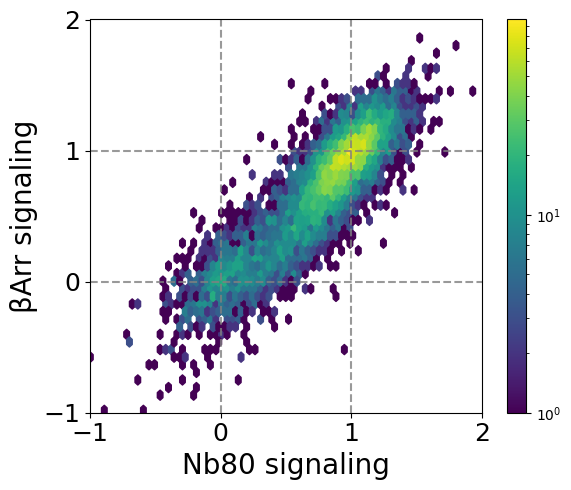

In [7]:
plt.figure(figsize=(6, 5))


x = b2AR_df_filt_missense['Nb80_isoP_reps_comb']
y = b2AR_df_filt_missense['BArr_isoP_reps_comb']
Nb80_BArr_isoP_lowess = lowess(y, x, frac=0.5, it=3, delta=0.0, xvals=x, is_sorted=False, missing='drop', return_sorted=True)
b2AR_df_filt_missense['Nb80_BArr_isoP_lowess'] = Nb80_BArr_isoP_lowess

b2AR_df_filt_missense['Nb80_BArr_isoP_residual'] = b2AR_df_filt_missense['BArr_isoP_reps_comb'] - b2AR_df_filt_missense['Nb80_BArr_isoP_lowess']
b2AR_df_filt_missense['Nb80_BArr_isoP_zscore'] = b2AR_df_filt_missense['Nb80_BArr_isoP_residual'] / \
((b2AR_df_filt_missense['Nb80_isoP_reps_comb_SEM'] + b2AR_df_filt_missense['BArr_isoP_reps_comb_SEM']) / 2)


######################

plt.figure(figsize=(6, 5))
plt.hexbin(b2AR_df_filt_missense['Nb80_isoP_reps_comb'], b2AR_df_filt_missense['BArr_isoP_reps_comb'], bins='log', gridsize=80)
#plt.plot(b2AR_sig_surfexp_simprat_df_filt['reps_comb'], b2AR_sig_surfexp_simprat_df_filt['Nb80_isoP_Gal4_reps_comb'], 'ko', alpha=0.1)

plt.ylim(-1, 2)
plt.xlabel('Nb80 signaling', fontsize=20)
plt.ylabel('βArr signaling', fontsize=20)
plt.xticks([-1, 0, 1, 2],fontsize=18)
plt.yticks([-1, 0, 1, 2], fontsize=18)
plt.axhline(y = 0, linestyle='dashed', color='gray', alpha=0.8)
plt.axhline(y = 1, linestyle='dashed', color='gray', alpha=0.8)
plt.axvline(x = 0, linestyle='dashed', color='gray', alpha=0.8)
plt.axvline(x = 1, linestyle='dashed', color='gray', alpha=0.8)
#plt.plot(b2AR_df_filt_missense.sort_values('Nb80_isoP_reps_comb')['Nb80_isoP_reps_comb'], \
#         b2AR_df_filt_missense.sort_values('Nb80_isoP_reps_comb')['Nb80_BArr_isoP_lowess'],color='k')
plt.xlim(-1, 2)
plt.ylim(-1, 2)

plt.colorbar()

plt.tight_layout()
print (scipy.stats.pearsonr(b2AR_df_filt_missense['Nb80_isoP_reps_comb'], b2AR_df_filt_missense['BArr_isoP_reps_comb']))

print (scipy.stats.spearmanr(b2AR_df_filt_missense['Nb80_isoP_reps_comb'], b2AR_df_filt_missense['BArr_isoP_reps_comb']))
print (len(b2AR_df_filt_missense))
#plt.savefig('b2AR_Nb80_vs_BArr_isoP_no_fit.png', dpi=250)

In [8]:
pos_list = []
num_considered = []
pvals = []
average_zscore = []
average_residual = []
IQR_list = []
for pos in range(2, 414):
    test_df = b2AR_df_filt_missense.loc[b2AR_df_filt_missense['pos'] == pos]
    compare_df = b2AR_df_filt_missense.loc[b2AR_df_filt_missense['pos'] != pos]
    if len(test_df) > 0:
        pvals.append(scipy.stats.mannwhitneyu(test_df['Nb80_BArr_isoP_zscore'], compare_df['Nb80_BArr_isoP_zscore'], alternative='two-sided', method='asymptotic')[1])
        IQR_list.append(abs (np.percentile(test_df['Nb80_BArr_isoP_zscore'], 75) - np.percentile(test_df['Nb80_BArr_isoP_zscore'], 25)))
        pos_list.append(pos)
        num_considered.append(len(test_df))
        average_zscore.append(np.average(test_df['Nb80_BArr_isoP_zscore']))
        average_residual.append(np.average(test_df['Nb80_BArr_isoP_residual']))
        
    else:
        pvals.append(np.nan)
        IQR_list.append(np.nan)
        pos_list.append(pos)
        num_considered.append(0)
        average_zscore.append(np.nan)
comp_df = pd.DataFrame(index=pos_list)
comp_df['num_considered_Nb80_BArr'] = num_considered
comp_df['average_zscore_Nb80_BArr'] = average_zscore
comp_df['average_residual_Nb80_BArr'] = average_residual
comp_df['pval_Nb80_BArr'] = pvals
comp_df['Nb80_BArr_IQR'] = IQR_list

In [9]:
results = statsmodels.stats.multitest.multipletests(comp_df['pval_Nb80_BArr'], alpha=0.1, method='fdr_bh', is_sorted=False, returnsorted=False)
comp_df['Nb80_BArr_FDR_bool'] = results[0]
comp_df['Nb80_BArr_FDR_val'] = results[1]
comp_df['minlog10pval_Nb80_BArr'] = -np.log10(comp_df['Nb80_BArr_FDR_val'])


In [10]:
import matplotlib.colors
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["orange","white","blue"])


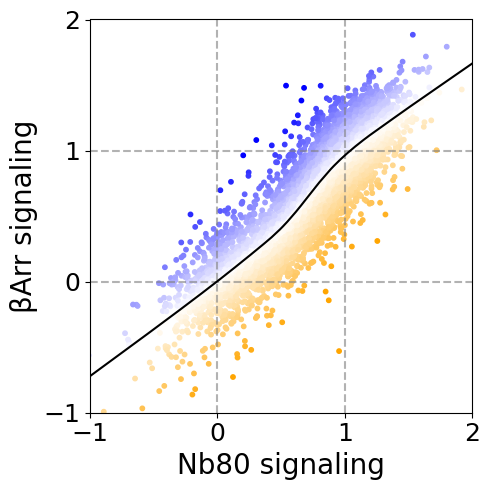

In [11]:
plt.figure(figsize=(5, 5))
plt.scatter(x = b2AR_df_filt_missense['Nb80_isoP_reps_comb'], y = b2AR_df_filt_missense['BArr_isoP_reps_comb'], \
           c = b2AR_df_filt_missense['Nb80_BArr_isoP_residual'], s=10,  cmap=cmap, vmin=-0.8, vmax=0.8)
plt.xlim(-0.2, 1.5)
plt.ylim(-1, 2)

plt.axhline(y=0, color='grey', linestyle='dashed', alpha=0.6)
plt.axhline(y=1, color='grey', linestyle='dashed', alpha=0.6)
plt.axvline(x=0, color='grey', linestyle='dashed', alpha=0.6)
plt.axvline(x=1, color='grey', linestyle='dashed', alpha=0.6)

plt.plot(b2AR_df_filt_missense.sort_values('Nb80_isoP_reps_comb')['Nb80_isoP_reps_comb'], \
         b2AR_df_filt_missense.sort_values('Nb80_isoP_reps_comb')['Nb80_BArr_isoP_lowess'],color='k')
plt.xticks([-1, 0, 1, 2], fontsize=18)
plt.yticks([-1, 0, 1, 2], fontsize=18)

plt.xlabel('Nb80 signaling', fontsize=20)
plt.ylabel('βArr signaling', fontsize=20)
plt.tight_layout()


plt.tight_layout()
#plt.savefig('b2AR_Nb80_BArr_hexbin_resids.png', dpi=200)

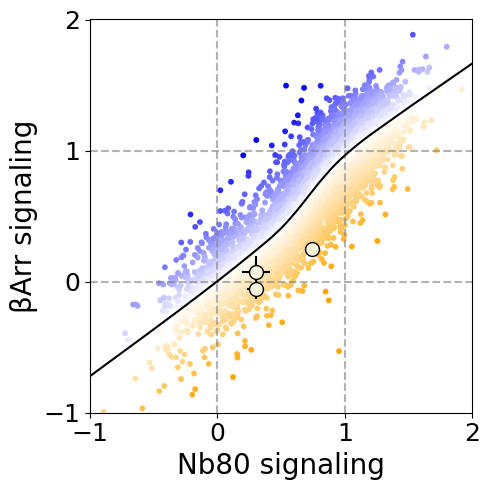

In [12]:
plt.figure(figsize=(5, 5))
plt.scatter(x = b2AR_df_filt_missense['Nb80_isoP_reps_comb'], y = b2AR_df_filt_missense['BArr_isoP_reps_comb'], \
           c = b2AR_df_filt_missense['Nb80_BArr_isoP_residual'], s=10,  cmap=cmap, vmin=-0.8, vmax=0.8)
plt.xlim(-0.2, 1.5)
plt.ylim(-1, 2)

plt.axhline(y=0, color='grey', linestyle='dashed', alpha=0.6)
plt.axhline(y=1, color='grey', linestyle='dashed', alpha=0.6)
plt.axvline(x=0, color='grey', linestyle='dashed', alpha=0.6)
plt.axvline(x=1, color='grey', linestyle='dashed', alpha=0.6)

plt.plot(b2AR_df_filt_missense.sort_values('Nb80_isoP_reps_comb')['Nb80_isoP_reps_comb'], \
         b2AR_df_filt_missense.sort_values('Nb80_isoP_reps_comb')['Nb80_BArr_isoP_lowess'],color='k')
plt.xticks([-1, 0, 1, 2], fontsize=18)
plt.yticks([-1, 0, 1, 2], fontsize=18)

plt.xlabel('Nb80 signaling', fontsize=20)
plt.ylabel('βArr signaling', fontsize=20)

sel_df = b2AR_df_filt_missense.loc[['F193A', 'Y219A', 'Y199A']]
#sel_df = b2AR_df_filt_missense.loc[b2AR_df_filt_missense['pos'] == 138]
#sel_df = b2AR_df_filt_missense.loc[b2AR_df_filt_missense['pos'] == 99]
#sel_df = b2AR_df_filt_missense.loc[b2AR_df_filt_missense['pos'] == 332]

plt.errorbar(sel_df['Nb80_isoP_reps_comb'], sel_df['BArr_isoP_reps_comb'], \
             marker='o', color='k', markerfacecolor='beige', linestyle='None', markersize=10, \
            yerr=sel_df['BArr_isoP_reps_comb_SEM'], xerr=sel_df['Nb80_isoP_reps_comb_SEM'])


plt.tight_layout()
#plt.savefig('b2AR_Nb80_BArr_hexbin_resids_highlight_known_bias_vars.png', dpi=200)

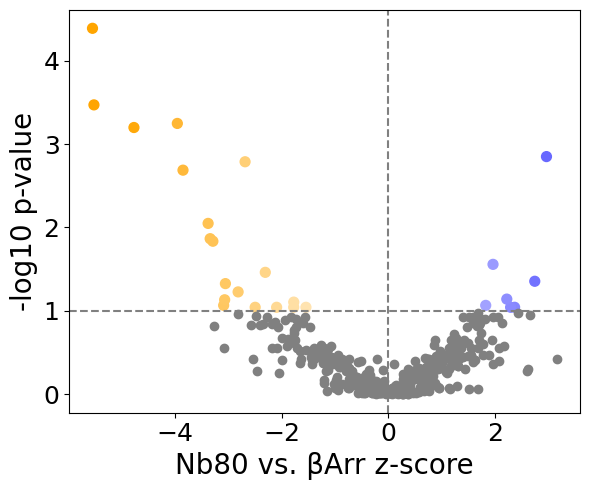

In [13]:
plt.figure(figsize=(6, 5))
below_thresh = comp_df.loc[comp_df['minlog10pval_Nb80_BArr'] < 1]
above_thresh = comp_df.loc[(comp_df['minlog10pval_Nb80_BArr'] >= 1)]

plt.plot(below_thresh['average_zscore_Nb80_BArr'], below_thresh['minlog10pval_Nb80_BArr'], color='gray', marker='o', linestyle='None')

plt.scatter(x = above_thresh['average_zscore_Nb80_BArr'], y = above_thresh['minlog10pval_Nb80_BArr'], \
           c = above_thresh['average_zscore_Nb80_BArr'], s=50,  cmap=cmap, vmin=-5, vmax=5)


plt.axvline(x = 0, color='grey', linestyle='dashed')
plt.axhline(y = 1, color='grey', linestyle='dashed')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.ylabel('-log10 p-value', fontsize=20)
plt.xlabel('Nb80 vs. βArr z-score', fontsize=20)
plt.tight_layout()
#plt.savefig('Nb80_BArr_volcano_orange_blue.png', dpi=200)

In [14]:
Nb80_bias_hits = comp_df.loc[(comp_df['Nb80_BArr_FDR_bool'] == True) & (comp_df['average_zscore_Nb80_BArr'] < 0)].sort_values('Nb80_BArr_FDR_val').index
BArr_bias_hits = comp_df.loc[(comp_df['Nb80_BArr_FDR_bool'] == True) & (comp_df['average_zscore_Nb80_BArr'] > 0)].sort_values('Nb80_BArr_FDR_val').index


In [15]:
from scipy.stats import fisher_exact


In [16]:
ECL2_resis = list(set(list(b2AR_df.loc[b2AR_df['topo'] == 'ECL2']['pos'])))
non_bias_hits = [i for i in range(2, 414) if i not in Nb80_bias_hits]

Nb80_bias_ECL2 = len([i for i in Nb80_bias_hits if i in ECL2_resis])
Nb80_bias_non_ECL2 = len([i for i in Nb80_bias_hits if i not in ECL2_resis])

non_Nb80_bias_ECL2 = len([i for i in non_bias_hits if i in ECL2_resis])
non_Nb80_bias_non_ECL2 = len([i for i in non_bias_hits if i not in ECL2_resis])

print (Nb80_bias_ECL2 + Nb80_bias_non_ECL2 + non_Nb80_bias_ECL2 + non_Nb80_bias_non_ECL2)

table = np.array([[Nb80_bias_ECL2, non_Nb80_bias_ECL2], [Nb80_bias_non_ECL2, non_Nb80_bias_non_ECL2] ])
res = fisher_exact(table, alternative='greater')

res

412


SignificanceResult(statistic=np.float64(5.555555555555555), pvalue=np.float64(0.01395715374898403))

In [17]:
all_ECL = list(set(list(b2AR_df.loc[b2AR_df['topo'].isin(['ECL1', 'ECL2', 'ECL3'])]['pos'])))

Nb80_bias_ECL = len([i for i in Nb80_bias_hits if i in all_ECL])
Nb80_bias_non_ECL = len([i for i in Nb80_bias_hits if i not in all_ECL])

non_Nb80_bias_ECL = len([i for i in non_bias_hits if i in all_ECL])
non_Nb80_bias_non_ECL = len([i for i in non_bias_hits if i not in all_ECL])

print (Nb80_bias_ECL + Nb80_bias_non_ECL + non_Nb80_bias_ECL + non_Nb80_bias_non_ECL)

table = np.array([[Nb80_bias_ECL, non_Nb80_bias_ECL], [Nb80_bias_non_ECL, non_Nb80_bias_non_ECL] ])
res = fisher_exact(table, alternative='greater')

res

412


SignificanceResult(statistic=np.float64(6.363636363636363), pvalue=np.float64(0.001013555473609707))

5.079271610102187
4.723709195362755


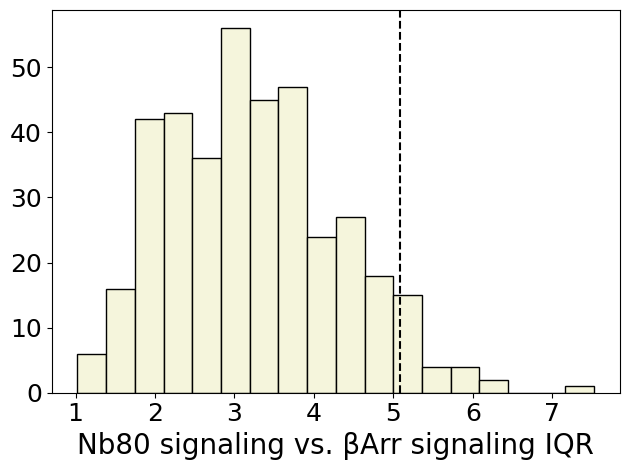

In [18]:
plt.hist(comp_df.loc[comp_df['Nb80_BArr_FDR_bool'] == False]['Nb80_BArr_IQR'], color='beige', edgecolor='k', bins=18)
plt.axvline(x = np.percentile(comp_df.loc[comp_df['Nb80_BArr_FDR_bool'] == False]['Nb80_BArr_IQR'], 95), color='k', linestyle='dashed')

plt.xlabel('Nb80 signaling vs. βArr signaling IQR', fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
#plt.xlim(0, 16)

print (np.percentile(comp_df.loc[comp_df['Nb80_BArr_FDR_bool'] == False]['Nb80_BArr_IQR'], 95))
print (np.percentile(comp_df.loc[comp_df['Nb80_BArr_FDR_bool'] == False]['Nb80_BArr_IQR'], 90))

plt.tight_layout()
plt.savefig('Nb80_BArr_sig_IQR_histo.png', dpi=200)

In [19]:
bias_switches = list(comp_df.loc[(comp_df['Nb80_BArr_FDR_bool'] == False) & (comp_df['Nb80_BArr_IQR'] > 5.079271610102187)].sort_values('Nb80_BArr_IQR', ascending=False).index)


In [20]:
print ([i for i in Nb80_bias_hits if i in Nb80_contacting])
print ([i for i in Nb80_bias_hits if i in BArr_contacting])
print ([i for i in BArr_bias_hits if i in Nb80_contacting])
print ([i for i in BArr_bias_hits if i in BArr_contacting])
print ([i for i in bias_switches if i in Nb80_contacting])
print ([i for i in bias_switches if i in BArr_contacting])

[330]
[]
[138, 139, 326]
[138, 139, 326]
[]
[328]


In [21]:
TM1 = [i-1 for i in range(35, 59)]
TM2 = [i-1 for i in range(72, 96)]
TM3 = [i-1 for i in range(107, 130)]
TM4 = [i-1 for i in range(151, 175)]
TM5 = [i-1 for i in range(197, 221)]
TM6 = [i-1 for i in range(275, 299)]
TM7 = [i-1 for i in range(306, 330)]


In [22]:
bias_func = list(BArr_bias_hits) + list(Nb80_bias_hits) + bias_switches
non_bias_func = [i for i in range(2, 414) if i not in bias_func]

bias_func_TM7 = len([i for i in bias_func if i in TM7])
bias_func_non_TM7 = len([i for i in bias_func if i not in TM7])

non_bias_func_TM7 = len([i for i in non_bias_func if i in TM7])
non_bias_func_non_TM7 = len([i for i in non_bias_func if i not in TM7])

#here testing for enrichment of bias functional residues in TM7
table = np.array([[bias_func_TM7, non_bias_func_TM7],[bias_func_non_TM7, non_bias_func_non_TM7]])
res = fisher_exact(table, alternative='greater')

res

SignificanceResult(statistic=np.float64(3.6847662141779787), pvalue=np.float64(0.010849137289176086))

In [23]:
comp_df.to_csv('Nb80_BArr_bias_comp_df.csv', sep=';')

In [24]:
bias_df = pd.DataFrame(columns = ['TM1', 'TM2', 'TM3', 'TM4', 'TM5', 'TM6', 'TM7'], index=['Nb80 biased', 'BArr biased', 'Bias switchers'])
TM1_list = []
TM1_list.append(len([i for i in Nb80_bias_hits if i in TM1])) 
TM1_list.append(len([i for i in BArr_bias_hits if i in TM1])) 
TM1_list.append(len([i for i in bias_switches if i in TM1])) 
bias_df['TM1'] = TM1_list

TM2_list = []
TM2_list.append(len([i for i in Nb80_bias_hits if i in TM2])) 
TM2_list.append(len([i for i in BArr_bias_hits if i in TM2])) 
TM2_list.append(len([i for i in bias_switches if i in TM2])) 
bias_df['TM2'] = TM2_list

TM3_list = []
TM3_list.append(len([i for i in Nb80_bias_hits if i in TM3])) 
TM3_list.append(len([i for i in BArr_bias_hits if i in TM3])) 
TM3_list.append(len([i for i in bias_switches if i in TM3])) 
bias_df['TM3'] = TM3_list

TM4_list = []
TM4_list.append(len([i for i in Nb80_bias_hits if i in TM4])) 
TM4_list.append(len([i for i in BArr_bias_hits if i in TM4])) 
TM4_list.append(len([i for i in bias_switches if i in TM4])) 
bias_df['TM4'] = TM4_list

TM5_list = []
TM5_list.append(len([i for i in Nb80_bias_hits if i in TM5])) 
TM5_list.append(len([i for i in BArr_bias_hits if i in TM5])) 
TM5_list.append(len([i for i in bias_switches if i in TM5])) 
bias_df['TM5'] = TM5_list

TM6_list = []
TM6_list.append(len([i for i in Nb80_bias_hits if i in TM6])) 
TM6_list.append(len([i for i in BArr_bias_hits if i in TM6])) 
TM6_list.append(len([i for i in bias_switches if i in TM6])) 
bias_df['TM6'] = TM6_list

TM7_list = []
TM7_list.append(len([i for i in Nb80_bias_hits if i in TM7])) 
TM7_list.append(len([i for i in BArr_bias_hits if i in TM7])) 
TM7_list.append(len([i for i in bias_switches if i in TM7])) 
bias_df['TM7'] = TM7_list

<Figure size 500x400 with 0 Axes>

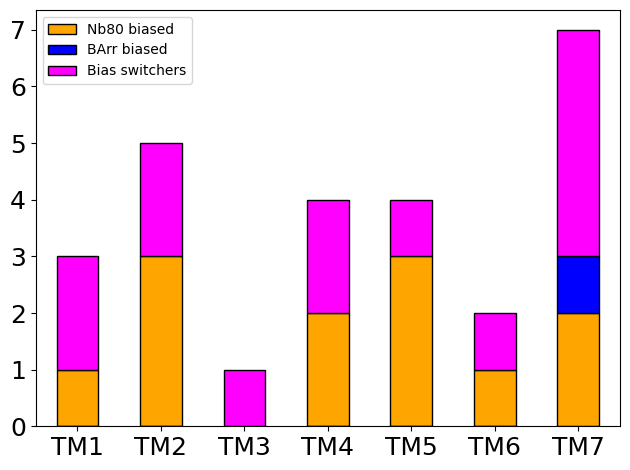

In [25]:
plt.figure(figsize=(5, 4))
my_pal = {'Nb80 biased': 'orange', \
          'BArr biased': 'blue', \
         'Bias switchers':'magenta'}
bias_df.T.plot.bar(stacked=True, edgecolor='k', color=my_pal)
plt.xticks(rotation=0, fontsize=18)
plt.yticks(fontsize=18)
plt.tight_layout()
#plt.savefig('bias_residues_per_TM.png', dpi=250)

SignificanceResult(statistic=np.float64(0.6725692979123095), pvalue=np.float64(0.004308166187686691))
PearsonRResult(statistic=np.float64(0.6319711314713221), pvalue=np.float64(0.008630019138777902))


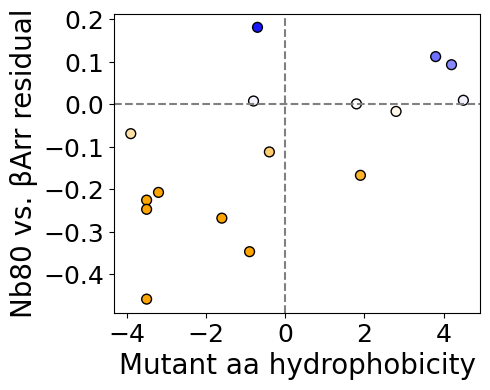

In [26]:
plt.figure(figsize=(5, 4))
sel_df = b2AR_df_filt_missense.loc[b2AR_df_filt_missense['pos'] == 308]
#sel_df = b2AR_df_filt_missense.loc[b2AR_df_filt_missense['pos'] == 193]

hydro_vals = list(sel_df['mut_hydro'])
resid_vals = list(sel_df['Nb80_BArr_isoP_residual'])
score_vals = list(sel_df['Nb80_isoP_reps_comb'])

#plt.plot(sel_df['mut_hydro'], sel_df['Nb80_BArr_isoP_residual'], 'ko', markersize=4)

plt.scatter(x=sel_df['mut_hydro'], y=sel_df['Nb80_BArr_isoP_residual'], \
         c=resid_vals, cmap=cmap, edgecolor='k', s=50, vmin=-0.2, vmax=0.2)


label = [i[-1] for i in list(sel_df.index)]

#for index_pos in range(0, len(hydro_vals)):
#    plt.annotate(label[index_pos], (hydro_vals[index_pos]+0.01, resid_vals[index_pos]), fontsize=12, fontweight='bold', color='k')


plt.xlabel('Mutant aa hydrophobicity', fontsize=20)
plt.ylabel('Nb80 vs. βArr residual', fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.axhline(y = 0, color='gray', linestyle='--')
#plt.axhline(y = 1, color='gray', linestyle='--')

plt.axvline(x = 0, color='gray', linestyle='--')

print (scipy.stats.spearmanr(sel_df['mut_hydro'], sel_df['Nb80_BArr_isoP_residual']))
print (scipy.stats.pearsonr(sel_df['mut_hydro'], sel_df['Nb80_BArr_isoP_residual']))
plt.tight_layout()
#plt.savefig('Y308_Nb80_BArr_bias.png', dpi=250)

In [27]:
x = b2AR_df_filt_missense['surfexp_reps_comb']
y = b2AR_df_filt_missense['Nb80_isoP_reps_comb']
Nb80_isoP_lowess = lowess(y, x, frac=0.5, it=3, delta=0.0, xvals=x, is_sorted=False, missing='drop', return_sorted=True)
b2AR_df_filt_missense['Nb80_isoP_lowess'] = Nb80_isoP_lowess
b2AR_df_filt_missense['Nb80_isoP_residual'] = b2AR_df_filt_missense['Nb80_isoP_reps_comb'] - b2AR_df_filt_missense['Nb80_isoP_lowess']
b2AR_df_filt_missense['Nb80_isoP_zscore'] = b2AR_df_filt_missense['Nb80_isoP_residual'] / b2AR_df_filt_missense['Nb80_isoP_reps_comb_SEM']


In [28]:
x = b2AR_df_filt_missense['surfexp_reps_comb']
y = b2AR_df_filt_missense['BArr_isoP_reps_comb']
BArr_isoP_lowess = lowess(y, x, frac=0.5, it=3, delta=0.0, xvals=x, is_sorted=False, missing='drop', return_sorted=True)
b2AR_df_filt_missense['BArr_isoP_lowess'] = BArr_isoP_lowess
b2AR_df_filt_missense['BArr_isoP_residual'] = b2AR_df_filt_missense['BArr_isoP_reps_comb'] - b2AR_df_filt_missense['BArr_isoP_lowess']
b2AR_df_filt_missense['BArr_isoP_zscore'] = b2AR_df_filt_missense['BArr_isoP_residual'] / b2AR_df_filt_missense['BArr_isoP_reps_comb_SEM']


In [29]:
Nb80_resid_dict = b2AR_df_filt_missense['Nb80_isoP_residual'].to_dict()
BArr_resid_dict = b2AR_df_filt_missense['BArr_isoP_residual'].to_dict()
bias_dict = b2AR_df_filt_missense['Nb80_BArr_isoP_residual'].to_dict()

In [30]:
aas = ['A', 'V', 'I', 'L', 'M', 'F', 'Y', 'W', 'S', 'T', 'N', 'Q', 'C', 'G', 'P', 'R', 'H', 'K', 'D', 'E']

b2AR_aa_seq = 'MGQPGNGSAFLLAPNRSHAPDHDVTQQRDEVWVVGMGIVMSLIVLAIVFGNVLVITAIAKFERLQTVTNYFITSLACADLVMGLAVVPFGAAHILMKMWTFGNFWCEFWTSIDVLCVTASIETLCVIAVDRYFAITSPFKYQSLLTKNKARVIILMVWIVSGLTSFLPIQMHWYRATHQEAINCYANETCCDFFTNQAYAIASSIVSFYVPLVIMVFVYSRVFQEAKRQLQKIDKSEGRFHVQNLSQVEQDGRTGHGLRRSSKFCLKEHKALKTLGIIMGTFTLCWLPFFIVNIVHVIQDNLIRKEVYILLNWIGYVNSGFNPLIYCRSPDFRIAFQELLCLRRSSLKAYGNGYSSNGNTGEQSGYHVEQEKENKLLCEDLPGTEDFVGHQGTVPSDNIDSQGRNCSTNDSLL'
poss = list(range(1, (len(b2AR_aa_seq)+1)))
ordered_vars = []
for pos in poss:
    for aa in aas:
        ordered_vars.append(b2AR_aa_seq[pos-1]+str(pos)+ aa)

In [31]:
ordered_vals = []
for var in ordered_vars:
    if var in Nb80_resid_dict:
        ordered_vals.append(Nb80_resid_dict[var])
    else:
        ordered_vals.append(np.nan)

import matplotlib.colors
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["purple","white","green"])

b2AR_Nb80_re = np.reshape(ordered_vals, (len(b2AR_aa_seq), 20))
b2AR_Nb80_heatmap = pd.DataFrame(b2AR_Nb80_re, columns=aas, index=np.arange(1, len(b2AR_aa_seq)+1)).T
b2AR_Nb80_heatmap.loc['Median'] = b2AR_Nb80_heatmap[:20].median(axis=0)
#b2AR_maxsig_heatmap.loc['Average'] = b2AR_maxsig_heatmap[:20].mean(axis=0)


In [32]:
ordered_vals = []
for var in ordered_vars:
    if var in BArr_resid_dict:
        ordered_vals.append(BArr_resid_dict[var])
    else:
        ordered_vals.append(np.nan)

import matplotlib.colors
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["purple","white","green"])

b2AR_BArr_re = np.reshape(ordered_vals, (len(b2AR_aa_seq), 20))
b2AR_BArr_heatmap = pd.DataFrame(b2AR_BArr_re, columns=aas, index=np.arange(1, len(b2AR_aa_seq)+1)).T
b2AR_BArr_heatmap.loc['Median'] = b2AR_BArr_heatmap[:20].median(axis=0)
#b2AR_maxsig_heatmap.loc['Average'] = b2AR_maxsig_heatmap[:20].mean(axis=0)


In [33]:
Nb80_uniq = sorted([i for i in Nb80_contacting if i not in BArr_contacting])
BArr_uniq = sorted([i for i in BArr_contacting if i not in Nb80_contacting])
shared = sorted([i for i in BArr_contacting if i in Nb80_contacting])


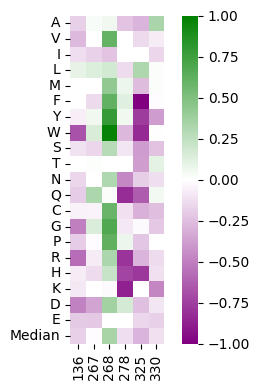

In [34]:
plt.figure(figsize=(4, 4))

sns.heatmap(b2AR_Nb80_heatmap[Nb80_uniq], cmap=cmap, center=0, vmin=-1, vmax=1, square=True)
#plt.xticks([])
plt.yticks()

plt.tight_layout()
plt.savefig('Nb80_resid_Nb80_uniq.png', dpi=250)

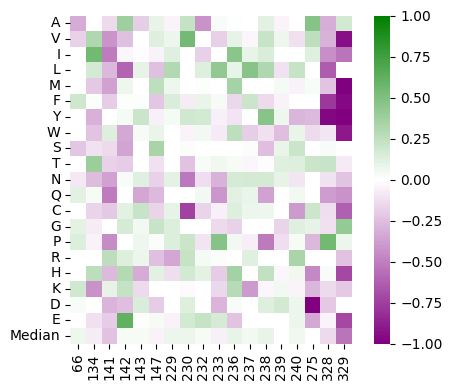

In [35]:
plt.figure(figsize=(5, 4))

sns.heatmap(b2AR_Nb80_heatmap[BArr_uniq], cmap=cmap, center=0, vmin=-1, vmax=1, square=True)
#plt.xticks([])
plt.yticks()

plt.tight_layout()
#plt.savefig('Nb80_resid_BArr_uniq.png', dpi=250)

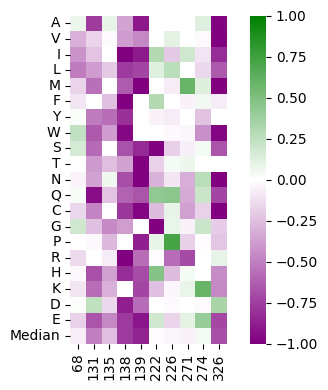

In [36]:
plt.figure(figsize=(5, 4))

sns.heatmap(b2AR_Nb80_heatmap[shared], cmap=cmap, center=0, vmin=-1, vmax=1, square=True)
#plt.xticks([])
plt.yticks()

plt.tight_layout()
#plt.savefig('Nb80_resid_shared.png', dpi=250)

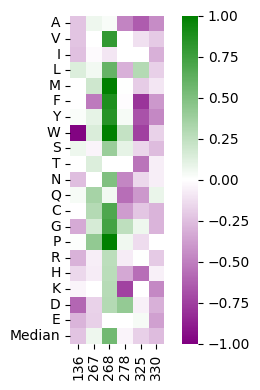

In [37]:
plt.figure(figsize=(4, 4))

sns.heatmap(b2AR_BArr_heatmap[Nb80_uniq], cmap=cmap, center=0, vmin=-1, vmax=1, square=True)
#plt.xticks([])
plt.yticks()

plt.tight_layout()
#plt.savefig('BArr_resid_Nb80_uniq.png', dpi=250)

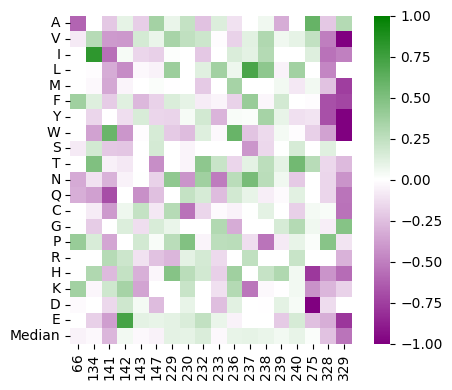

In [38]:
plt.figure(figsize=(5, 4))

sns.heatmap(b2AR_BArr_heatmap[BArr_uniq], cmap=cmap, center=0, vmin=-1, vmax=1, square=True)
#plt.xticks([])
plt.yticks()

plt.tight_layout()
#plt.savefig('BArr_resid_BArr_uniq.png', dpi=250)

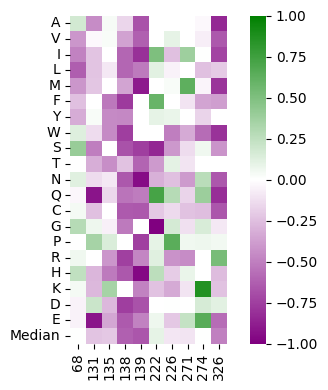

In [39]:
plt.figure(figsize=(5, 4))

sns.heatmap(b2AR_BArr_heatmap[shared], cmap=cmap, center=0, vmin=-1, vmax=1, square=True)
#plt.xticks([])
plt.yticks()

plt.tight_layout()
#plt.savefig('BArr_resid_shared.png', dpi=250)

In [40]:
overlap_LoF_hits = [76, 78, 79, 82, 88, 106, 113, 114, 117, 118, 119, 121, 127, 128, 129, 131, 135, 136, 138, 139, 141, 165, 190, 191, 193, 199, 203, 204, 207, 208, 209, 219, 286, 289, 290, 293, 294, 312, 315, 318, 322, 325, 326, 327, 328, 329, 330]
overlap_GoF_hits = [87, 101, 124, 130, 170, 187, 189, 218, 231, 251, 268, 283, 313, 345, 355, 359, 362, 375, 392, 410]
overlap_CoF_hits = [47, 120, 122, 215, 306, 311, 321, 332]



In [41]:
sig_dict = {}
for pos in range(1, len(b2AR_aa_seq)):
    if pos in overlap_LoF_hits:
        sig_dict[pos] = 1
    elif pos in overlap_GoF_hits:
        sig_dict[pos] = 2
    elif pos in overlap_CoF_hits:
        sig_dict[pos] = 3
    else:
        sig_dict[pos] = 0

In [42]:
[sig_dict[i] for i in Nb80_uniq]

[1, 0, 2, 0, 1, 1]

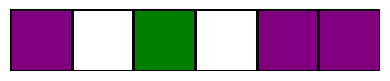

In [43]:
plt.figure(figsize=(4, 1.2))
sig_df = pd.DataFrame.from_dict(sig_dict, orient='index')
cmap = ['white','purple','green']#,'red']
sns.heatmap(sig_df.loc[Nb80_uniq].T, cmap=cmap, square=True, linewidths=1, linecolor='k', cbar=False)
#plt.xticks(rotation=45, fontsize=16)
plt.xticks([])

plt.yticks([])

plt.tight_layout()
#plt.savefig('overlap_cats_uniq_Nb80.png', dpi=250)

In [44]:
[sig_dict[i] for i in BArr_uniq]

[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1]

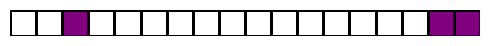

In [45]:
plt.figure(figsize=(5, 1.2))
sig_df = pd.DataFrame.from_dict(sig_dict, orient='index')
cmap = ['white','purple']#,'green','red']
sns.heatmap(sig_df.loc[BArr_uniq].T, cmap=cmap, square=True, linewidths=1, linecolor='k', cbar=False)
plt.xticks([])
plt.yticks([])

plt.tight_layout()
#plt.savefig('overlap_cats_uniq_barr.png', dpi=250)

In [80]:
[sig_dict[i] for i in shared]

[0, 1, 1, 1, 1, 0, 0, 0, 0, 1]

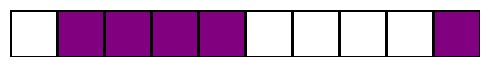

In [46]:
plt.figure(figsize=(5, 1.2))
sig_df = pd.DataFrame.from_dict(sig_dict, orient='index')
cmap = ['white','purple']#,'green','red']
sns.heatmap(sig_df.loc[shared].T, cmap=cmap, square=True, linewidths=1, linecolor='k', cbar=False)
plt.xticks([])
plt.yticks([])

plt.tight_layout()
#plt.savefig('overlap_cats_shared.png', dpi=250)

In [47]:
ordered_vals = []
for var in ordered_vars:
    if var in bias_dict:
        ordered_vals.append(bias_dict[var])
    else:
        ordered_vals.append(np.nan)

import matplotlib.colors
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["purple","white","green"])

b2AR_bias_re = np.reshape(ordered_vals, (len(b2AR_aa_seq), 20))
b2AR_bias_heatmap = pd.DataFrame(b2AR_bias_re, columns=aas, index=np.arange(1, len(b2AR_aa_seq)+1)).T
b2AR_bias_heatmap.loc['Median'] = b2AR_bias_heatmap[:20].median(axis=0)
#b2AR_maxsig_heatmap.loc['Average'] = b2AR_maxsig_heatmap[:20].mean(axis=0)


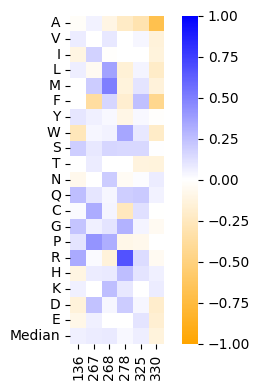

In [48]:
plt.figure(figsize=(4, 4))
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["orange","white","blue"])

sns.heatmap(b2AR_bias_heatmap[Nb80_uniq], cmap=cmap, center=0, vmin=-1, vmax=1, square=True)
#plt.xticks([])
plt.yticks()

plt.tight_layout()
#plt.savefig('bias_resid_Nb80_uniq.png', dpi=250)

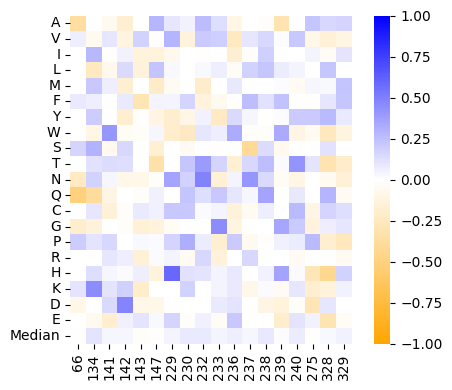

In [49]:
plt.figure(figsize=(5, 4))

sns.heatmap(b2AR_bias_heatmap[BArr_uniq], cmap=cmap, center=0, vmin=-1, vmax=1, square=True)
#plt.xticks([])
plt.yticks()

plt.tight_layout()
#plt.savefig('bias_resid_BArr_uniq.png', dpi=250)

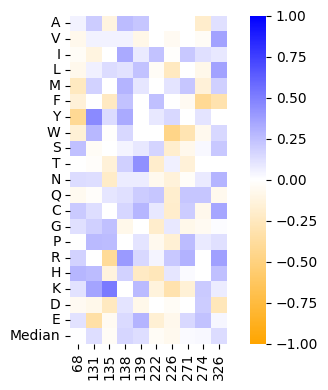

In [50]:
plt.figure(figsize=(5, 4))

sns.heatmap(b2AR_bias_heatmap[shared], cmap=cmap, center=0, vmin=-1, vmax=1, square=True)
#plt.xticks([])
plt.yticks()

plt.tight_layout()
#plt.savefig('bias_resid_shared.png', dpi=250)

In [51]:
BArr_biased = [138, 139, 255, 326, 373, 406]
Nb80_biased = [51, 71, 83, 86, 99, 101, 102, 168, 173, 181, 184, 185, 196, 209, 211, 285, 306, 323, 330]
bias_switches = [332, 308, 199, 411, 328, 189, 46, 356,  40, 279, 111, 318,  63, 166, 327,  84, 313, 298, 387, 176]

In [52]:
bias_dict = {}
for pos in range(1, len(b2AR_aa_seq)):
    if pos in Nb80_biased:
        bias_dict[pos] = 1
    elif pos in BArr_biased:
        bias_dict[pos] = 2
    elif pos in bias_switches:
        bias_dict[pos] = 3
    else:
        bias_dict[pos] = 0

In [53]:
[bias_dict[i] for i in Nb80_uniq]

[0, 0, 0, 0, 0, 1]

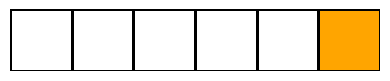

In [54]:
plt.figure(figsize=(4, 1.2))
sig_df = pd.DataFrame.from_dict(bias_dict, orient='index')
cmap = ['white','orange']#,'blue','magenta']
sns.heatmap(sig_df.loc[Nb80_uniq].T, cmap=cmap, square=True, linewidths=1, linecolor='k', cbar=False)
#plt.xticks(rotation=45, fontsize=16)
plt.xticks([])

plt.yticks([])

plt.tight_layout()
#plt.savefig('overlap_cats_uniq_Nb80.png', dpi=250)

In [55]:
[bias_dict[i] for i in BArr_uniq]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0]

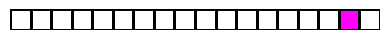

In [56]:
plt.figure(figsize=(4, 1.2))
sig_df = pd.DataFrame.from_dict(bias_dict, orient='index')
cmap = ['white','orange','blue','magenta']
sns.heatmap(sig_df.loc[BArr_uniq].T, cmap=cmap, square=True, linewidths=1, linecolor='k', cbar=False)
#plt.xticks(rotation=45, fontsize=16)
plt.xticks([])

plt.yticks([])

plt.tight_layout()
plt.savefig('overlap_cats_uniq_BArr.png', dpi=250)

In [57]:
[bias_dict[i] for i in shared]

[0, 0, 0, 2, 2, 0, 0, 0, 0, 2]

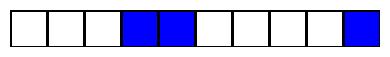

In [58]:
plt.figure(figsize=(4, 1.2))
sig_df = pd.DataFrame.from_dict(bias_dict, orient='index')
cmap = ['white','orange','blue']#,'magenta']
sns.heatmap(sig_df.loc[shared].T, cmap=cmap, square=True, linewidths=1, linecolor='k', cbar=False)
#plt.xticks(rotation=45, fontsize=16)
plt.xticks([])

plt.yticks([])

plt.tight_layout()
#plt.savefig('overlap_cats_shared.png', dpi=250)

In [60]:
bias_CoF = []
for pos in comp_df.index:
    if pos in bias_switches:
        bias_CoF.append(True)
    else:
        bias_CoF.append(False)

In [61]:
comp_df['bias_switch'] = bias_CoF

In [62]:
comp_df.to_excel('Nb80_BArr_bias_supp_table.xlsx')